# Maps

Generate maps from tweet data

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

from IPython.display import clear_output

In [2]:
DATADIRLOCATIONS = "../data/locations/"
DATADIRTEXT = "../data/text/"
COORDINATESFILE = "coordinates.csv"
COUNTRY = "country"
IDSTR = "id_str"
LATITUDE = "latitude"
LOCATION = "location"
LONGITUDE = "longitude"
SCREENNAME = "screenname"
UNKNOWN = "-"
USER = "user"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

def read_coordinates():
    return(pd.read_csv(DATADIRLOCATIONS+COORDINATESFILE,index_col=LOCATION))

def read_user_locations(user_location_file):
    return(pd.read_csv(DATADIRLOCATIONS+user_location_file,index_col=SCREENNAME))

def remove_other_location_fields(user_locations):
    locations = []
    for i in range(0,len(user_locations)):
        first_field = str(user_locations.iloc[i][COUNTRY]).split(",")[0].strip()
        if len(first_field) > 0 and first_field[0] >= 'a' and first_field[0] <= 'z': 
            first_field = re.sub("^.",first_field[0].upper(),first_field)
        locations.append(first_field)
    user_locations[LOCATION] = locations
    return(user_locations)

def read_tweets(file_pattern):
    file_name_list = sorted(os.listdir(DATADIRTEXT))
    tweets_list = []
    for file_name in file_name_list:
        if re.search(file_pattern,file_name):
            squeal(file_name)
            tweets_list.append(pd.read_csv(DATADIRTEXT+file_name,index_col=IDSTR,compression="gzip"))
    return(pd.concat(tweets_list))

In [25]:
MONTH = "202002"

tweets = read_tweets(MONTH)

20200229-23.out.gz


In [26]:
LOCATIONSFILE = f"locations-{MONTH}.csv"

user_locations = read_user_locations(LOCATIONSFILE)
user_locations = user_locations[user_locations[COUNTRY] != UNKNOWN]
user_locations = remove_other_location_fields(user_locations)

In [27]:
coordinates = read_coordinates()
user_locations_with_coordinates = user_locations[user_locations[LOCATION].isin(coordinates.index)]

In [28]:
location_counts = {}
counter = 0
for user in tweets[tweets[USER].isin(user_locations_with_coordinates.index)][USER]:
    location = user_locations_with_coordinates.loc[user][LOCATION]
    if not location in location_counts: location_counts[location] = 1
    else: location_counts[location] += 1
    counter += 1
    if counter % 10000 == 0: squeal(counter)
{location:location_counts[location] for location in sorted(location_counts.keys(),key=lambda l:location_counts[l],reverse=True)}

3410000


{'Amsterdam': 591572,
 'Rotterdam': 250813,
 'Utrecht': 210000,
 'Den Haag': 150816,
 'Antwerpen': 118164,
 'Groningen': 115252,
 'Eindhoven': 64928,
 'Nijmegen': 58342,
 'Tilburg': 50784,
 'Brussel': 50602,
 'Amersfoort': 50240,
 'Zwolle': 48227,
 'Haarlem': 48075,
 'Gent': 47256,
 'Arnhem': 46594,
 'Leiden': 45778,
 'Almere': 45707,
 'Hilversum': 45044,
 'Brussels': 40008,
 'Enschede': 39153,
 'Breda': 36498,
 'The Hague': 34539,
 'Antwerp': 33695,
 'Deventer': 32422,
 'Leeuwarden': 32251,
 'Alkmaar': 32177,
 'Delft': 28972,
 'Brugge': 28078,
 'Dordrecht': 27524,
 'Zoetermeer': 25672,
 'Gouda': 25200,
 'Mechelen': 24152,
 "'s-Hertogenbosch": 23131,
 'Apeldoorn': 22863,
 'Wageningen': 20966,
 'Leuven': 19746,
 'Kortrijk': 19637,
 'Hengelo': 18408,
 'Ghent': 17874,
 'Lelystad': 17247,
 'Amstelveen': 17163,
 'Oostende': 16935,
 'Assen': 16803,
 'Maastricht': 16208,
 'Schiedam': 16117,
 'Ede': 15314,
 'Emmen': 15088,
 'Purmerend': 14571,
 'Helmond': 14202,
 'Alphen aan den Rijn': 13514,


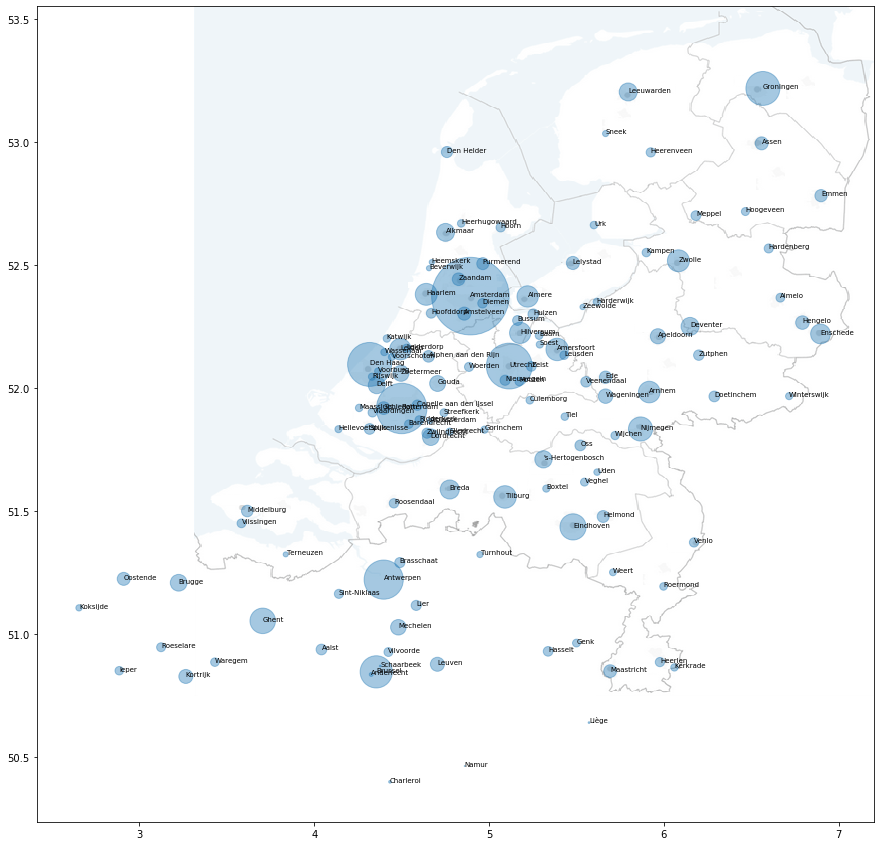

In [29]:
BLOBFACTOR = 0.01

x = []
y = []
s = []
seen = {}
for location in location_counts:
    key = str(coordinates.loc[location][LONGITUDE])+" "+str(coordinates.loc[location][LATITUDE])
    if not key in seen:
        x.append(coordinates.loc[location][LONGITUDE])
        y.append(coordinates.loc[location][LATITUDE])
        s.append(location_counts[location]*BLOBFACTOR)
        seen[key] = len(x)-1
    else:
        s[seen[key]] = (s[seen[key]]/BLOBFACTOR+location_counts[location])*BLOBFACTOR

img_netherlands = mpimg.imread("nederland.png")
plt.figure(figsize=(15,15))
plt.imshow(img_netherlands,alpha=0.4,extent=[3.3,7.2,50.75,53.55],aspect="auto")
plt.scatter(x,y,s=s,alpha=0.4)
seen = {}
for location in location_counts:
    key = str(coordinates.loc[location][LONGITUDE])+" "+str(coordinates.loc[location][LATITUDE])
    if not key in seen:
        plt.annotate(location,(coordinates.loc[location][LONGITUDE],coordinates.loc[location][LATITUDE]),fontsize=7)
        seen[key] = True
plt.show()

In [30]:
def get_locations_without_coordinates():
    user_locations_without_coordinates = user_locations[~user_locations[LOCATION].isin(coordinates.index)]

    missing_location_counts = {}
    counter = 0
    for user in tweets[tweets[USER].isin(user_locations_without_coordinates.index)][USER]:
        location = user_locations_without_coordinates.loc[user][LOCATION]
        if not location in missing_location_counts: missing_location_counts[location] = 1
        else: missing_location_counts[location] += 1
        counter += 1
        if counter % 10000 == 0: squeal(counter)
    return(missing_location_counts)

In [31]:
missing_location_counts = get_locations_without_coordinates()
{location:missing_location_counts[location] \
    for location in sorted(missing_location_counts.keys(),key=lambda l:missing_location_counts[l],reverse=True)}

6540000


{'Nederland': 888699,
 'The Netherlands': 302142,
 'Netherlands': 224350,
 'België': 183603,
 'Belgium': 124905,
 'Zuid-Holland': 51120,
 'Noord-Brabant': 40987,
 'Holland': 39869,
 'Gelderland': 37396,
 'NL': 36724,
 'Noord-Holland': 34269,
 'Friesland': 28316,
 'South Africa': 23921,
 'Limburg': 23918,
 'Vlaanderen': 20480,
 'Worldwide': 18227,
 'Drenthe': 18061,
 'Overijssel': 17680,
 'Zeeland': 15232,
 'Europe': 14984,
 'Earth': 14362,
 'Twente': 12913,
 'Westland': 12309,
 'Thuis': 11525,
 'Duitsland': 11329,
 'Lansingerland': 11165,
 'Suriname': 9874,
 'London': 9644,
 'Achterhoek': 9465,
 'Cape Town': 9403,
 'Ergens': 9094,
 'InACastleDarkOrAFortressStrong': 8602,
 'Europa': 8556,
 'New York': 8496,
 'Westindische buurt': 8442,
 'Oostduinkerke   Strand': 8414,
 'Fryslân': 8324,
 'HSL-Zuid': 8288,
 'Somewhere': 8215,
 'Belgie': 8153,
 'The netherlands': 7839,
 'Sint-Petersburg': 7725,
 'Pretoria': 7416,
 'She/her': 7274,
 'Ternat': 7013,
 'Netherlands 🇳🇱': 6929,
 'Sittard-Geleen'